In [1]:
#libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import requests

In [11]:
def send_message(message, channel):
    requests.post(f"https://ntfy.sh/{channel}",
        data=message.encode(encoding='utf-8'))
    
def leer_matriz(nombre_archivo):
    matriz = []
    with open(nombre_archivo, 'r') as archivo:
        archivo.readline()
        archivo.readline()
        for linea in archivo:
            fila = [float(valor) for valor in linea.strip().split()]
            matriz.append(fila)
    return matriz

In [2]:
# Floyd-Warshall algorithm
def floyd_warshall(AdjMatrix):
    n = len(AdjMatrix)
    cost = np.copy(AdjMatrix)
    cost[cost == 0] = np.inf
    np.fill_diagonal(cost, 0)
    for k in range(n):
        for i in range(n):
            for j in range(n):
                cost[i, j] = min(cost[i, j], cost[i, k] + cost[k, j])
    return cost

In [3]:
def count_trips_mibici(data_user, threshold = 5, complement = False):
    viajes_user = data_user.groupby([data_user[['Origen_Id', 'Destino_Id']].min(axis=1), data_user[['Origen_Id', 'Destino_Id']].max(axis=1)]).size().reset_index(name='counts')
    viajes_user.columns = ['Est_A', 'Est_B', 'counts']
    if not complement:
        viajes_user = viajes_user[viajes_user['counts'] >= threshold]
    else:
        viajes_user = viajes_user[viajes_user['counts'] < threshold]
    if viajes_user.empty:
        return None
    total = viajes_user['counts'].sum()
    viajes_user['prob'] = viajes_user['counts']/total
    viajes_user = viajes_user.sort_values(by = 'prob', ascending = False).reset_index(drop=True)
    return viajes_user

def compute_matrix(counter_user, normalized = False, self_loops = False):
    if not self_loops:
        counter_user = counter_user[counter_user['Est_A'] != counter_user['Est_B']]
    vertex = list(set(counter_user['Est_A'].unique().tolist() + counter_user['Est_B'].unique().tolist()))
    matrix = np.zeros((len(vertex), len(vertex)))
    for i in range(len(counter_user)):
        current_trip = counter_user.iloc[i]
        count = current_trip["counts"]
        estA = current_trip["Est_A"]
        estB = current_trip["Est_B"]

        matrix[vertex.index(estA)][vertex.index(estB)] = count
        matrix[vertex.index(estB)][vertex.index(estA)] = count
    if normalized:
        D = np.sum(matrix, axis = 1)
        D = np.diag(D)
        D = np.linalg.inv(np.sqrt(D))
        matrix = D @ matrix @ D
    return matrix

def log_prob_matrix(counter_user, normalized = False, self_loops = False):
    if not self_loops:
        counter_user = counter_user[counter_user['Est_A'] != counter_user['Est_B']]
    vertex = list(set(counter_user['Est_A'].unique().tolist() + counter_user['Est_B'].unique().tolist()))
    matrix = np.zeros((len(vertex), len(vertex)))
    for i in range(len(counter_user)):
        current_trip = counter_user.iloc[i]
        count = -np.log(current_trip["prob"])
        estA = current_trip["Est_A"]
        estB = current_trip["Est_B"]

        matrix[vertex.index(estA)][vertex.index(estB)] = count
        matrix[vertex.index(estB)][vertex.index(estA)] = count
    if normalized:
        D = np.sum(matrix, axis = 1)
        D = np.diag(D)
        D = np.linalg.inv(np.sqrt(D))
        matrix = D @ matrix @ D
    return matrix

In [4]:
dir = '/home/user/Desktop/Datos/'
#dir = '/Users/antoniomendez/Desktop/Tesis/Datos/datos_limpios/'

In [5]:
data_2019 = pd.read_csv(f'{dir}mibici/mibici_2019.csv')

In [6]:
# generate data
dates = [f"2019-01-{str(i).zfill(2)}" for i in range(5, 8)]
data = []
for date in dates:
    print("Procesando fecha: ", date, end="\r")
    current_data = data_2019[data_2019['Inicio_del_viaje'].str.startswith(date)]
    current_counter = count_trips_mibici(current_data)
    current_matrix = log_prob_matrix(current_counter)
    current_s = floyd_warshall(current_matrix)
    data.append(current_s)

In [7]:
data[0]

array([[ 0.        , 31.2622361 , 31.54991817, ..., 21.56954303,
        27.36843364, 31.69587208],
       [31.2622361 ,  0.        , 10.63715468, ..., 26.07175144,
        31.87064205, 31.56234069],
       [31.54991817, 10.63715468,  0.        , ..., 26.35943351,
        32.15832412, 31.85002276],
       ...,
       [21.56954303, 26.07175144, 26.35943351, ...,  0.        ,
        16.41542601, 30.94330148],
       [27.36843364, 31.87064205, 32.15832412, ..., 16.41542601,
         0.        , 32.36881656],
       [31.69587208, 31.56234069, 31.85002276, ..., 30.94330148,
        32.36881656,  0.        ]])

In [8]:
distances = [value for matrix in data for row in matrix for value in row if value != 0 and value != np.inf]
distances = np.unique(distances)
distances

array([ 4.15675013,  4.20327014,  4.30973887, ..., 54.75817244,
       55.1170177 , 55.34595911])

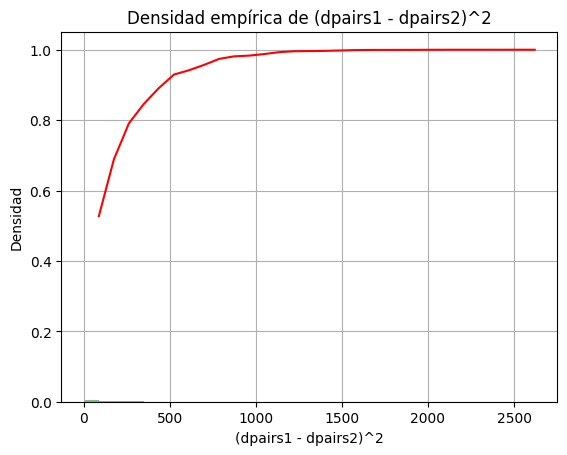

In [9]:
diff_squared = [(i - j)**2 for i in distances for j in distances]
density, bins, _ = plt.hist(diff_squared, bins=30, density=True, alpha=0.5, color='g')
count, _ = np.histogram(diff_squared, bins)
cdf = np.cumsum(count)
plt.plot(bins[1:], cdf / cdf[-1], 'r')
plt.title('Densidad empírica de (dpairs1 - dpairs2)^2')
plt.xlabel('(dpairs1 - dpairs2)^2')
plt.ylabel('Densidad')
plt.grid()
plt.show()

In [10]:
s1 = 1 / np.sqrt(np.median(diff_squared)/2)
s1

0.1620289008044339

In [12]:
est_2019 = leer_matriz(f"{dir}/Adj_mibici/matrices_estaciones/est_2019.txt")

In [14]:
est_2019 = np.array(est_2019)
ubis = [[est_2019[i][1], est_2019[i][2]] for i in range(len(est_2019))]

In [15]:
dist_squared = [(ubis[i][0] - ubis[j][0])**2 + (ubis[i][1] - ubis[j][1])**2 for i in range(len(ubis)) for j in range(len(ubis))]

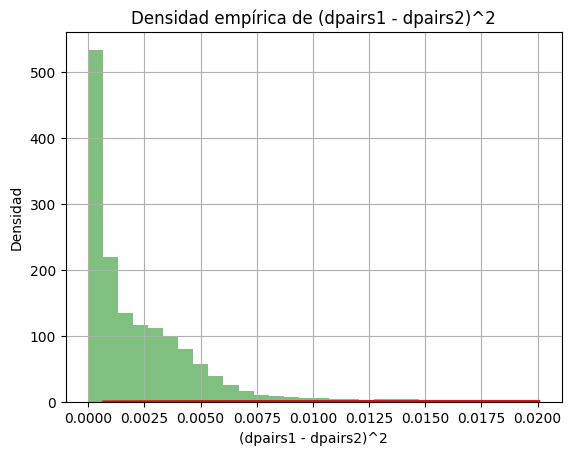

In [16]:
density, bins, _ = plt.hist(dist_squared, bins=30, density=True, alpha=0.5, color='g')
count, _ = np.histogram(dist_squared, bins)
cdf = np.cumsum(count)
plt.plot(bins[1:], cdf / cdf[-1], 'r')
plt.title('Densidad empírica de (dpairs1 - dpairs2)^2')
plt.xlabel('(dpairs1 - dpairs2)^2')
plt.ylabel('Densidad')
plt.grid()
plt.show()

In [17]:
s2 = 1 / np.sqrt(np.median(dist_squared)/2)
s2

38.98274493303222